In [6]:
import shap
import cv2
from PIL import Image
import dataFrameTools
import numpy as np
from pathlib import Path
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [7]:
df=dataFrameTools.normalizeDF(0)
reduced=pd.read_csv("../Data/BIKED_reduced.csv", index_col=0)
reduced.BIKESTYLE=pd.Categorical(reduced.BIKESTYLE)
df['BIKESTYLE']=reduced.BIKESTYLE.cat.codes
images=[]
for i in df.index.values:
    filePath=Path("../Processed Images/Grayscale/(" + str(i) + ").png")
    image=cv2.imread(str(filePath),0)
#     image = np.array(Image.open(filePath))
    images.append(image)
images=np.array(images)
#scale image values
images=images/255.0
split = train_test_split(df, images, test_size=0.25, random_state=42)
dtrain, dtest, itrain, itest = split
itrain=tf.expand_dims(itrain, -1)
itest=tf.expand_dims(itest, -1)

ytrain=dtrain["BIKESTYLE"]
ytest=dtest["BIKESTYLE"]
dtest=dtest.drop("BIKESTYLE", axis=1)
dtrain=dtrain.drop("BIKESTYLE", axis=1)
imdims=np.shape(itrain[1])
ddims=len(dtrain.columns)
ydims=max(df["BIKESTYLE"])+1

Loaded Imputed Dataframe in  0.8101954460144043 seconds


In [8]:
def create_cnn(imdims, ydims):
    model=tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=imdims))
    
    model.add(layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2),name="e1"))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(filters=128, kernel_size=3, strides=(5, 5),name="e2"))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.))

    model.add(layers.Flatten())
    
    model.add(layers.Dense(200, name="e3"))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))
    
#     model.add(layers.Dense(200, name="e4"))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(ydims, name="e5"))
    model.add(layers.Softmax())
    return model
def create_dnn(ddims, ydims):
    model=tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=ddims))
    
    model.add(layers.Dense(200, name="e1"))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Dense(200, name="e2"))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Dense(200, name="e3"))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Dense(200, name="e4"))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.2))
    
#     model.add(layers.Dense(200, name="e5"))
#     model.add(layers.BatchNormalization())
# #     model.add(layers.LeakyReLU())
#     model.add(layers.ReLU())
#     model.add(layers.Dropout(0.2))
    
#     model.add(layers.Dense(200, name="e6"))
#     model.add(layers.BatchNormalization())
# #     model.add(layers.LeakyReLU())
#     model.add(layers.ReLU())
#     model.add(layers.Dropout(0.2))
    
    
    model.add(layers.Dense(ydims, name="e7"))
    model.add(layers.Softmax())
    return model


In [9]:
dnnmodel=create_dnn(ddims, ydims)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
dnnmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = dnnmodel.fit(x=dtrain, y=ytrain, epochs=1000, batch_size=1000, validation_data=(dtest, ytest), callbacks=[callback])
dnnmodel.summary()

Epoch 1/1000
4/4 [==============================] - 1s 57ms/step - loss: 2.9476 - accuracy: 0.0455 - val_loss: 2.9410 - val_accuracy: 0.0541
Epoch 2/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.9421 - accuracy: 0.0547 - val_loss: 2.9397 - val_accuracy: 0.1339
Epoch 3/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.9363 - accuracy: 0.0700 - val_loss: 2.9382 - val_accuracy: 0.2163
Epoch 4/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.9263 - accuracy: 0.0993 - val_loss: 2.9367 - val_accuracy: 0.2713
Epoch 5/1000
4/4 [==============================] - 0s 19ms/step - loss: 2.9193 - accuracy: 0.1144 - val_loss: 2.9350 - val_accuracy: 0.3165
Epoch 6/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.9099 - accuracy: 0.1433 - val_loss: 2.9329 - val_accuracy: 0.3573
Epoch 7/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.8975 - accuracy: 0.1696 - val_loss: 2.9304 - val_accuracy: 0.3856
Epoch 8/1000


Epoch 59/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.3746 - accuracy: 0.6729 - val_loss: 2.4717 - val_accuracy: 0.6090
Epoch 60/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.3703 - accuracy: 0.6767 - val_loss: 2.4688 - val_accuracy: 0.6135
Epoch 61/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.3671 - accuracy: 0.6817 - val_loss: 2.4660 - val_accuracy: 0.6126
Epoch 62/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.3662 - accuracy: 0.6814 - val_loss: 2.4632 - val_accuracy: 0.6108
Epoch 63/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.3629 - accuracy: 0.6853 - val_loss: 2.4608 - val_accuracy: 0.6099
Epoch 64/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.3634 - accuracy: 0.6811 - val_loss: 2.4586 - val_accuracy: 0.6090
Epoch 65/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.3641 - accuracy: 0.6847 - val_loss: 2.4564 - val_accuracy: 0.6082
Epoch 

4/4 [==============================] - 0s 18ms/step - loss: 2.2687 - accuracy: 0.7793 - val_loss: 2.4092 - val_accuracy: 0.6480
Epoch 117/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.2617 - accuracy: 0.7828 - val_loss: 2.4084 - val_accuracy: 0.6454
Epoch 118/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.2632 - accuracy: 0.7822 - val_loss: 2.4061 - val_accuracy: 0.6498
Epoch 119/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.2590 - accuracy: 0.7863 - val_loss: 2.4034 - val_accuracy: 0.6534
Epoch 120/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.2589 - accuracy: 0.7872 - val_loss: 2.4015 - val_accuracy: 0.6534
Epoch 121/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.2566 - accuracy: 0.7875 - val_loss: 2.3980 - val_accuracy: 0.6543
Epoch 122/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.2581 - accuracy: 0.7887 - val_loss: 2.3956 - val_accuracy: 0.6525
Epoch 123/1000

4/4 [==============================] - 0s 18ms/step - loss: 2.2172 - accuracy: 0.8194 - val_loss: 2.3744 - val_accuracy: 0.6676
Epoch 174/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.2173 - accuracy: 0.8203 - val_loss: 2.3730 - val_accuracy: 0.6693
Epoch 175/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.2155 - accuracy: 0.8245 - val_loss: 2.3725 - val_accuracy: 0.6693
Epoch 176/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.2168 - accuracy: 0.8200 - val_loss: 2.3736 - val_accuracy: 0.6649
Epoch 177/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.2139 - accuracy: 0.8227 - val_loss: 2.3738 - val_accuracy: 0.6631
Epoch 178/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.2118 - accuracy: 0.8242 - val_loss: 2.3722 - val_accuracy: 0.6649
Epoch 179/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.2141 - accuracy: 0.8239 - val_loss: 2.3691 - val_accuracy: 0.6667
Epoch 180/1000

4/4 [==============================] - 0s 17ms/step - loss: 2.1892 - accuracy: 0.8452 - val_loss: 2.3390 - val_accuracy: 0.7004
Epoch 231/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.1910 - accuracy: 0.8443 - val_loss: 2.3385 - val_accuracy: 0.7004
Epoch 232/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.1896 - accuracy: 0.8460 - val_loss: 2.3384 - val_accuracy: 0.7012
Epoch 233/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.1890 - accuracy: 0.8469 - val_loss: 2.3387 - val_accuracy: 0.7021
Epoch 234/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.1900 - accuracy: 0.8449 - val_loss: 2.3403 - val_accuracy: 0.6995
Epoch 235/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.1868 - accuracy: 0.8484 - val_loss: 2.3404 - val_accuracy: 0.6968
Epoch 236/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.1872 - accuracy: 0.8469 - val_loss: 2.3400 - val_accuracy: 0.6995
Epoch 237/1000

4/4 [==============================] - 0s 18ms/step - loss: 2.1583 - accuracy: 0.8783 - val_loss: 2.3126 - val_accuracy: 0.7252
Epoch 288/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.1558 - accuracy: 0.8806 - val_loss: 2.3127 - val_accuracy: 0.7270
Epoch 289/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.1576 - accuracy: 0.8777 - val_loss: 2.3128 - val_accuracy: 0.7261
Epoch 290/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.1565 - accuracy: 0.8818 - val_loss: 2.3132 - val_accuracy: 0.7278
Epoch 291/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.1566 - accuracy: 0.8791 - val_loss: 2.3129 - val_accuracy: 0.7305
Epoch 292/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.1577 - accuracy: 0.8780 - val_loss: 2.3124 - val_accuracy: 0.7305
Epoch 293/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.1563 - accuracy: 0.8800 - val_loss: 2.3118 - val_accuracy: 0.7323
Epoch 294/1000

4/4 [==============================] - 0s 17ms/step - loss: 2.1362 - accuracy: 0.9001 - val_loss: 2.3200 - val_accuracy: 0.7181
Epoch 345/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.1355 - accuracy: 0.8989 - val_loss: 2.3195 - val_accuracy: 0.7190
Epoch 346/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.1347 - accuracy: 0.9010 - val_loss: 2.3186 - val_accuracy: 0.7207
Epoch 347/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.1358 - accuracy: 0.8995 - val_loss: 2.3184 - val_accuracy: 0.7190
Epoch 348/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.1344 - accuracy: 0.9007 - val_loss: 2.3189 - val_accuracy: 0.7199
Epoch 349/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.1341 - accuracy: 0.9013 - val_loss: 2.3161 - val_accuracy: 0.7252
Epoch 350/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.1345 - accuracy: 0.9001 - val_loss: 2.3129 - val_accuracy: 0.7296
Epoch 351/1000

4/4 [==============================] - 0s 17ms/step - loss: 2.1018 - accuracy: 0.9356 - val_loss: 2.2998 - val_accuracy: 0.7438
Epoch 402/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.1020 - accuracy: 0.9362 - val_loss: 2.2997 - val_accuracy: 0.7429
Epoch 403/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.1028 - accuracy: 0.9356 - val_loss: 2.3001 - val_accuracy: 0.7447
Epoch 404/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.1028 - accuracy: 0.9353 - val_loss: 2.3011 - val_accuracy: 0.7411
Epoch 405/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.1023 - accuracy: 0.9362 - val_loss: 2.3004 - val_accuracy: 0.7411
Epoch 406/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.1011 - accuracy: 0.9359 - val_loss: 2.2999 - val_accuracy: 0.7429
Epoch 407/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.0999 - accuracy: 0.9368 - val_loss: 2.2990 - val_accuracy: 0.7438
Epoch 408/1000

4/4 [==============================] - 0s 17ms/step - loss: 2.0922 - accuracy: 0.9427 - val_loss: 2.2955 - val_accuracy: 0.7411
Epoch 459/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.0908 - accuracy: 0.9433 - val_loss: 2.2966 - val_accuracy: 0.7420
Epoch 460/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.0905 - accuracy: 0.9444 - val_loss: 2.2976 - val_accuracy: 0.7376
Epoch 461/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.0906 - accuracy: 0.9441 - val_loss: 2.2992 - val_accuracy: 0.7367
Epoch 462/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.0902 - accuracy: 0.9444 - val_loss: 2.3004 - val_accuracy: 0.7332
Epoch 463/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.0902 - accuracy: 0.9444 - val_loss: 2.3008 - val_accuracy: 0.7349
Epoch 464/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.0894 - accuracy: 0.9450 - val_loss: 2.3009 - val_accuracy: 0.7349
Epoch 465/1000

4/4 [==============================] - 0s 17ms/step - loss: 2.0877 - accuracy: 0.9450 - val_loss: 2.2967 - val_accuracy: 0.7367
Epoch 516/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.0860 - accuracy: 0.9480 - val_loss: 2.2967 - val_accuracy: 0.7376
Epoch 517/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.0860 - accuracy: 0.9471 - val_loss: 2.2965 - val_accuracy: 0.7349
Epoch 518/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.0862 - accuracy: 0.9474 - val_loss: 2.2954 - val_accuracy: 0.7358
Epoch 519/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.0865 - accuracy: 0.9471 - val_loss: 2.2938 - val_accuracy: 0.7402
Epoch 520/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.0864 - accuracy: 0.9465 - val_loss: 2.2924 - val_accuracy: 0.7438
Epoch 521/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.0851 - accuracy: 0.9477 - val_loss: 2.2903 - val_accuracy: 0.7465
Epoch 522/1000

4/4 [==============================] - 0s 18ms/step - loss: 2.0770 - accuracy: 0.9572 - val_loss: 2.2832 - val_accuracy: 0.7544
Epoch 573/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.0773 - accuracy: 0.9566 - val_loss: 2.2825 - val_accuracy: 0.7571
Epoch 574/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.0768 - accuracy: 0.9574 - val_loss: 2.2818 - val_accuracy: 0.7571
Epoch 575/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.0769 - accuracy: 0.9580 - val_loss: 2.2824 - val_accuracy: 0.7553
Epoch 576/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.0777 - accuracy: 0.9569 - val_loss: 2.2845 - val_accuracy: 0.7473
Epoch 577/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.0772 - accuracy: 0.9574 - val_loss: 2.2878 - val_accuracy: 0.7473
Epoch 578/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.0757 - accuracy: 0.9583 - val_loss: 2.2874 - val_accuracy: 0.7473
Epoch 579/1000

4/4 [==============================] - 0s 17ms/step - loss: 2.0728 - accuracy: 0.9604 - val_loss: 2.2987 - val_accuracy: 0.7358
Epoch 630/1000
4/4 [==============================] - 0s 16ms/step - loss: 2.0731 - accuracy: 0.9592 - val_loss: 2.2989 - val_accuracy: 0.7394
Epoch 631/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.0722 - accuracy: 0.9607 - val_loss: 2.2997 - val_accuracy: 0.7385
Epoch 632/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.0720 - accuracy: 0.9610 - val_loss: 2.3003 - val_accuracy: 0.7394
Epoch 633/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.0713 - accuracy: 0.9616 - val_loss: 2.2996 - val_accuracy: 0.7385
Epoch 634/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.0713 - accuracy: 0.9610 - val_loss: 2.2991 - val_accuracy: 0.7358
Epoch 635/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.0728 - accuracy: 0.9604 - val_loss: 2.3000 - val_accuracy: 0.7358
Epoch 636/1000

In [10]:
shap.initjs()

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


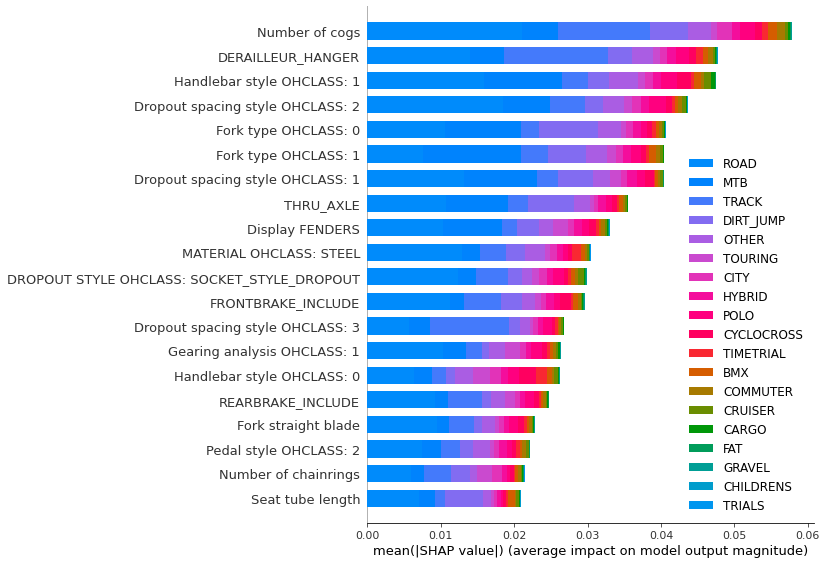

In [11]:
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
explainer = shap.DeepExplainer(dnnmodel,dtrain.iloc[:500,:].values)
shap_values = explainer.shap_values(dtrain.iloc[500:1000,:].values)
shap.summary_plot(shap_values, dtrain, class_names=sorted(reduced["BIKESTYLE"].unique()))

Number of cogs
Fork straight blade
DERAILLEUR_HANGER
MATERIAL OHCLASS: STEEL
Dropout spacing style OHCLASS: 1
Dropout spacing style OHCLASS: 2
Dropout spacing style OHCLASS: 3
Fork type OHCLASS: 0
Fork type OHCLASS: 1
Handlebar style OHCLASS: 0
Handlebar style OHCLASS: 1


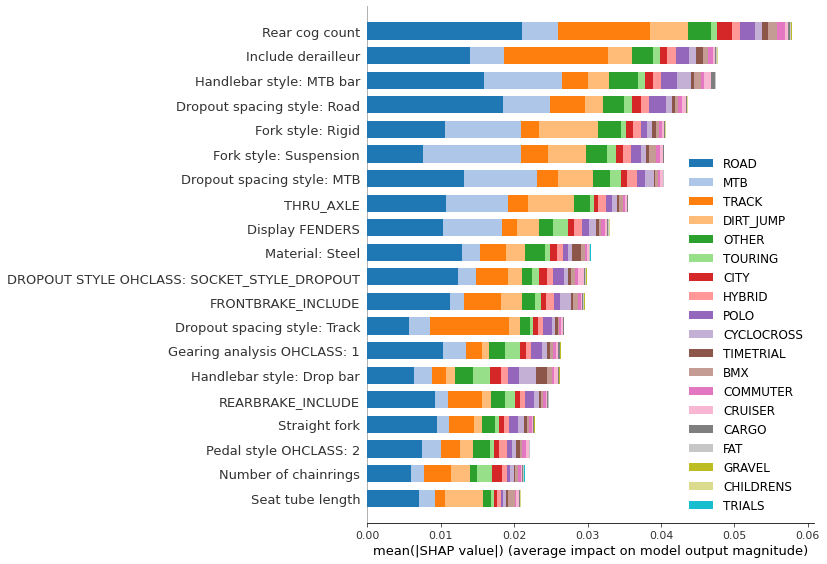

In [12]:
#Ganerate a better shap plot

feature_names=list(dtest.columns)

#Translate some common parameters into clearer terminology
transdict={
    "Number of cogs": "Rear cog count",
    "MATERIAL OHCLASS: STEEL": "Material: Steel",
    "DERAILLEUR_HANGER": "Include derailleur",
    "Handlebar style OHCLASS: 1": "Handlebar style: MTB bar",
    "Handlebar style OHCLASS: 0": "Handlebar style: Drop bar",
    "Fork type OHCLASS: 0": "Fork style: Rigid",
    "Fork type OHCLASS: 1": "Fork style: Suspension",
    "Fork straight blade": "Straight fork",
    "Dropout spacing style OHCLASS: 2": "Dropout spacing style: Road",
    "Dropout spacing style OHCLASS: 1": "Dropout spacing style: MTB",
    "Dropout spacing style OHCLASS: 3": "Dropout spacing style: Track"
}
for i in range(len(feature_names)):
    if feature_names[i] in transdict:
        print(feature_names[i])
        feature_names[i]=transdict[feature_names[i]]   
shap.summary_plot(shap_values, dtrain, feature_names=feature_names, class_names=sorted(reduced["BIKESTYLE"].unique()),color=plt.get_cmap("tab20"))

In [13]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(df.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.to_csv("SHAPdf.csv")
feature_importance.head(20)

,col_name,feature_importance_vals
396,Number of cogs,1.523118
1037,DERAILLEUR_HANGER,1.256019
2339,Handlebar style OHCLASS: 1,1.250988
1972,Dropout spacing style OHCLASS: 2,1.148942
2129,Fork type OHCLASS: 0,1.069200
2130,Fork type OHCLASS: 1,1.064879
1971,Dropout spacing style OHCLASS: 1,1.064409
911,THRU_AXLE,0.935010
778,Display FENDERS,0.869584
1357,MATERIAL OHCLASS: STEEL,0.799999


In [14]:
cnnmodel=create_cnn(imdims, ydims)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
cnnmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = cnnmodel.fit(x=itrain, y=ytrain, epochs=1000, batch_size=100, validation_data=(itest, ytest), callbacks=[callback])

cnnmodel.summary()

Epoch 1/1000
34/34 [==============================] - 9s 43ms/step - loss: 2.6843 - accuracy: 0.3927 - val_loss: 2.8206 - val_accuracy: 0.4096
Epoch 2/1000
34/34 [==============================] - 1s 28ms/step - loss: 2.5322 - accuracy: 0.5331 - val_loss: 2.6887 - val_accuracy: 0.4096
Epoch 3/1000
34/34 [==============================] - 1s 28ms/step - loss: 2.4673 - accuracy: 0.6022 - val_loss: 2.6493 - val_accuracy: 0.4096
Epoch 4/1000
34/34 [==============================] - 1s 29ms/step - loss: 2.4131 - accuracy: 0.6584 - val_loss: 2.6363 - val_accuracy: 0.4096
Epoch 5/1000
34/34 [==============================] - 1s 28ms/step - loss: 2.3597 - accuracy: 0.7145 - val_loss: 2.6343 - val_accuracy: 0.4096
Epoch 6/1000
34/34 [==============================] - 1s 28ms/step - loss: 2.3149 - accuracy: 0.7512 - val_loss: 2.6331 - val_accuracy: 0.4096
Epoch 7/1000
34/34 [==============================] - 1s 28ms/step - loss: 2.2779 - accuracy: 0.7884 - val_loss: 2.6332 - val_accuracy: 0.4096

Epoch 58/1000
34/34 [==============================] - 1s 32ms/step - loss: 2.0379 - accuracy: 0.9944 - val_loss: 2.3840 - val_accuracy: 0.6684
Epoch 59/1000
34/34 [==============================] - 1s 29ms/step - loss: 2.0380 - accuracy: 0.9944 - val_loss: 2.3829 - val_accuracy: 0.6711
Epoch 60/1000
34/34 [==============================] - 1s 29ms/step - loss: 2.0377 - accuracy: 0.9944 - val_loss: 2.3790 - val_accuracy: 0.6711
Epoch 61/1000
34/34 [==============================] - 1s 28ms/step - loss: 2.0375 - accuracy: 0.9947 - val_loss: 2.3782 - val_accuracy: 0.6720
Epoch 62/1000
34/34 [==============================] - 1s 29ms/step - loss: 2.0374 - accuracy: 0.9947 - val_loss: 2.3795 - val_accuracy: 0.6684
Epoch 63/1000
34/34 [==============================] - 1s 31ms/step - loss: 2.0370 - accuracy: 0.9950 - val_loss: 2.3813 - val_accuracy: 0.6658
Epoch 64/1000
34/34 [==============================] - 1s 28ms/step - loss: 2.0372 - accuracy: 0.9950 - val_loss: 2.3842 - val_accuracy:

In [15]:
def comb_cnn(imdims):
    model=tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=imdims))
#     model.add(layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2),name="c1"))
    model.add(layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2),name="c1"))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.1))

#     model.add(layers.Conv2D(filters=128, kernel_size=3, strides=(5, 5),name="c2"))
    model.add(layers.Conv2D(filters=128, kernel_size=3, strides=(5, 5),name="c2"))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.1))

    model.add(layers.Flatten())
    
#     model.add(layers.Dense(200, name="c4"))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))
    return model

def comb_dnn(ddims):
    model=tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=ddims))
    
    model.add(layers.Dense(200, name="d1"))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Dense(200, name="d2"))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Dense(200, name="d3"))
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Dense(200, name="d4"))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.1))
    return model

def create_comb(comb_input,ydims):
    imdims=comb_input[0]
    ddims=comb_input[1]
    cnn=comb_cnn(imdims)
    dnn=comb_dnn(ddims)
    combinedInput=concatenate([cnn.output, dnn.output])
    x=layers.Dense(200, name="f1")(combinedInput)
    x=layers.BatchNormalization()(x)
#     x=layers.LeakyReLU()(x)
    x=layers.ReLU()(x)
    x=layers.Dropout(0.1)(x)
#     x=layers.Dense(ydims, name="f2")(x)
#     x=layers.BatchNormalization()(x)
#     x=layers.LeakyReLU()(x)
#     x=layers.Dropout(0.3)(x)
    x=layers.Dense(ydims, name="f3")(x)
#     x=layers.Dense(ydims, name="f2")(combinedInput)
    model=Model(inputs=[cnn.input, dnn.input], outputs=x)
    return model

In [16]:
comb_input=[imdims,ddims]
combtest=[itest, dtest]
combtrain=[itrain,dtrain]
combmodel=create_comb(comb_input, ydims)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
combmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = combmodel.fit(x=combtrain, y=ytrain, epochs=200, batch_size=10, validation_data=(combtest, ytest), callbacks=[callback])
combmodel.summary()

Epoch 1/200
339/339 [==============================] - 5s 13ms/step - loss: 1.6055 - accuracy: 0.5683 - val_loss: 1.4618 - val_accuracy: 0.5842
Epoch 2/200
339/339 [==============================] - 4s 12ms/step - loss: 0.8882 - accuracy: 0.7305 - val_loss: 1.6184 - val_accuracy: 0.5461
Epoch 3/200
339/339 [==============================] - 4s 13ms/step - loss: 0.4134 - accuracy: 0.8791 - val_loss: 1.2532 - val_accuracy: 0.6702
Epoch 4/200
339/339 [==============================] - 4s 12ms/step - loss: 0.2336 - accuracy: 0.9368 - val_loss: 1.4596 - val_accuracy: 0.6117
Epoch 5/200
339/339 [==============================] - 4s 12ms/step - loss: 0.1541 - accuracy: 0.9616 - val_loss: 1.3706 - val_accuracy: 0.6507
Epoch 6/200
339/339 [==============================] - 4s 13ms/step - loss: 0.0985 - accuracy: 0.9781 - val_loss: 1.2703 - val_accuracy: 0.6826
Epoch 7/200
339/339 [==============================] - 4s 12ms/step - loss: 0.1244 - accuracy: 0.9675 - val_loss: 1.3911 - val_accuracy:

339/339 [==============================] - 4s 12ms/step - loss: 0.0275 - accuracy: 0.9923 - val_loss: 1.7226 - val_accuracy: 0.6631
Epoch 58/200
339/339 [==============================] - 4s 12ms/step - loss: 0.0242 - accuracy: 0.9932 - val_loss: 3.2274 - val_accuracy: 0.6099
Epoch 59/200
339/339 [==============================] - 4s 12ms/step - loss: 0.0297 - accuracy: 0.9938 - val_loss: 2.0095 - val_accuracy: 0.6232
Epoch 60/200
339/339 [==============================] - 4s 12ms/step - loss: 0.0323 - accuracy: 0.9911 - val_loss: 1.9576 - val_accuracy: 0.6941
Epoch 61/200
339/339 [==============================] - 4s 12ms/step - loss: 0.0272 - accuracy: 0.9932 - val_loss: 1.9498 - val_accuracy: 0.6853
Epoch 62/200
339/339 [==============================] - 4s 12ms/step - loss: 0.0276 - accuracy: 0.9932 - val_loss: 2.0644 - val_accuracy: 0.6463
Epoch 63/200
339/339 [==============================] - 4s 13ms/step - loss: 0.0344 - accuracy: 0.9902 - val_loss: 2.0063 - val_accuracy: 0.665